# Day 4: DCC-GARCH - Multivariate Volatility

## Learning Objectives
- Understand Dynamic Conditional Correlation (DCC)
- Model time-varying correlations
- Portfolio volatility with DCC
- Correlation breakdown during crises

## Key Formulas

**DCC Model:**
$$Q_t = (1-a-b)\bar{Q} + a(z_{t-1}z_{t-1}') + b Q_{t-1}$$
$$R_t = \text{diag}(Q_t)^{-1/2} Q_t \text{diag}(Q_t)^{-1/2}$$

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from arch import arch_model
from scipy import stats
from pathlib import Path

DATA_DIR = Path('../datasets/raw_data')
TRADING_DAYS = 252

df = pd.read_csv(DATA_DIR / 'combined_adjusted_close.csv', index_col='Date', parse_dates=True)
prices = df.ffill().dropna()
returns = prices.pct_change().dropna() * 100

print("="*60)
print("DCC-GARCH: MULTIVARIATE VOLATILITY - DAY 4")
print("="*60)

DCC-GARCH: MULTIVARIATE VOLATILITY - DAY 4


## 1. Univariate GARCH for Each Asset

In [2]:
# Select assets for multivariate analysis
assets = ['SPY', 'AAPL', 'MSFT', 'JPM', 'XOM']
n_assets = len(assets)

# Ensure all assets exist
assets = [a for a in assets if a in returns.columns]
asset_returns = returns[assets].dropna()

print(f"\nAnalyzing {len(assets)} assets: {assets}")
print(f"Data: {len(asset_returns)} observations")

# Fit GARCH(1,1) to each asset
garch_results = {}
conditional_vols = {}
std_residuals = {}

print("\n" + "="*60)
print("UNIVARIATE GARCH FITS")
print("="*60)
print(f"{'Asset':<8} {'ω':<12} {'α':<10} {'β':<10} {'Persist':<10}")
print("-"*50)

for asset in assets:
    model = arch_model(asset_returns[asset], vol='GARCH', p=1, q=1)
    result = model.fit(disp='off')
    garch_results[asset] = result
    
    # Store conditional volatility and standardized residuals
    conditional_vols[asset] = result.conditional_volatility
    std_residuals[asset] = result.std_resid
    
    omega = result.params['omega']
    alpha = result.params['alpha[1]']
    beta = result.params['beta[1]']
    persist = alpha + beta
    
    print(f"{asset:<8} {omega:<12.6f} {alpha:<10.4f} {beta:<10.4f} {persist:<10.4f}")


Analyzing 5 assets: ['SPY', 'AAPL', 'MSFT', 'JPM', 'XOM']
Data: 1834 observations

UNIVARIATE GARCH FITS
Asset    ω            α          β          Persist   
--------------------------------------------------
SPY      0.044896     0.1661     0.8002     0.9663    
AAPL     0.146993     0.1052     0.8515     0.9568    
MSFT     0.102176     0.1009     0.8637     0.9646    
JPM      0.141614     0.1031     0.8476     0.9507    
XOM      0.039448     0.0685     0.9208     0.9894    


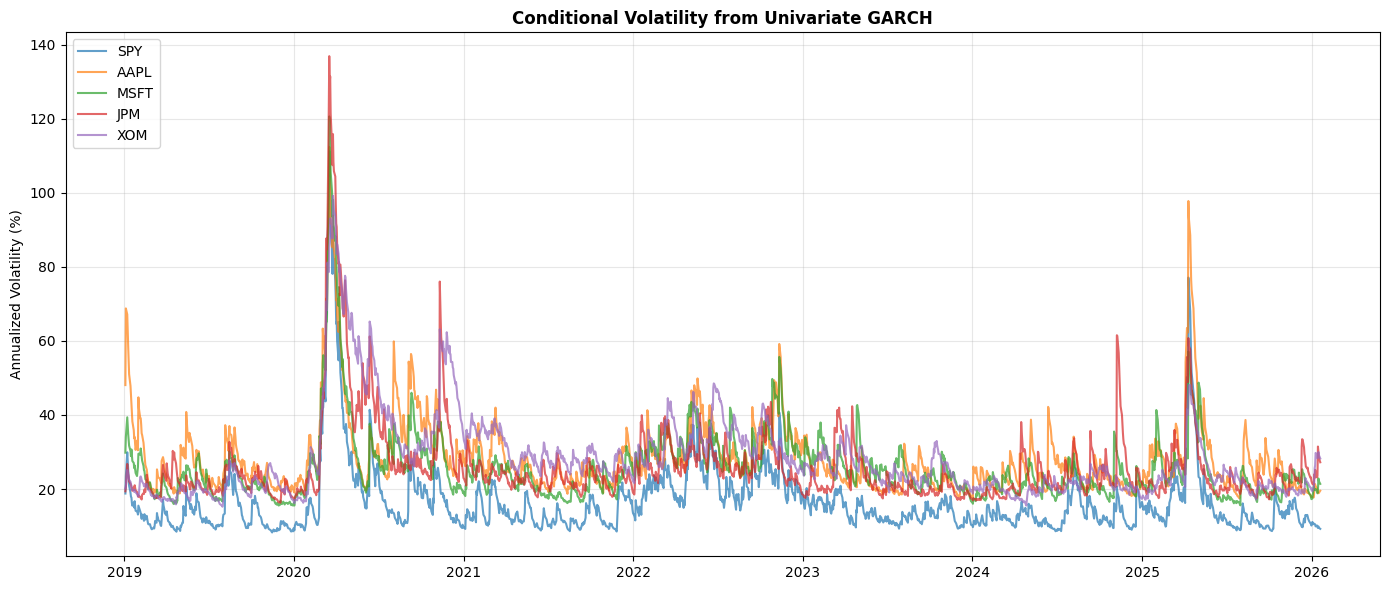

In [3]:
# Create DataFrames
vol_df = pd.DataFrame(conditional_vols, index=asset_returns.index)
z_df = pd.DataFrame(std_residuals, index=asset_returns.index).dropna()

# Plot conditional volatilities
fig, ax = plt.subplots(figsize=(14, 6))
for asset in assets:
    ax.plot(vol_df[asset] * np.sqrt(TRADING_DAYS), label=asset, alpha=0.7)
ax.set_title('Conditional Volatility from Univariate GARCH', fontweight='bold')
ax.set_ylabel('Annualized Volatility (%)')
ax.legend(loc='upper left')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 2. Dynamic Conditional Correlation (DCC)

In [4]:
# Simple DCC estimation
# Step 1: Unconditional correlation of standardized residuals
Q_bar = z_df.corr().values

print("\n" + "="*60)
print("UNCONDITIONAL CORRELATION MATRIX (Q̄)")
print("="*60)
Q_bar_df = pd.DataFrame(Q_bar, index=assets, columns=assets)
print(Q_bar_df.round(3))


UNCONDITIONAL CORRELATION MATRIX (Q̄)
        SPY   AAPL   MSFT    JPM    XOM
SPY   1.000  0.695  0.729  0.589  0.375
AAPL  0.695  1.000  0.590  0.296  0.195
MSFT  0.729  0.590  1.000  0.277  0.107
JPM   0.589  0.296  0.277  1.000  0.431
XOM   0.375  0.195  0.107  0.431  1.000


In [5]:
# Step 2: DCC parameters estimation (simplified)
# Using grid search for a and b
def estimate_dcc(z_matrix, Q_bar, a_init=0.05, b_init=0.94):
    """Estimate DCC model with given parameters."""
    T, n = z_matrix.shape
    
    # Initialize Q
    Q_t = Q_bar.copy()
    R_t_list = []
    
    a, b = a_init, b_init
    
    for t in range(T):
        # Update Q
        z_t = z_matrix[t, :].reshape(-1, 1)
        Q_t = (1 - a - b) * Q_bar + a * (z_t @ z_t.T) + b * Q_t
        
        # Normalize to get correlation
        Q_diag = np.diag(Q_t)
        D_inv = np.diag(1 / np.sqrt(Q_diag))
        R_t = D_inv @ Q_t @ D_inv
        R_t_list.append(R_t)
    
    return R_t_list

# Estimate DCC
z_matrix = z_df.values
dcc_correlations = estimate_dcc(z_matrix, Q_bar, a_init=0.05, b_init=0.90)

print("\nDCC model estimated with a=0.05, b=0.90")
print(f"Generated {len(dcc_correlations)} time-varying correlation matrices")


DCC model estimated with a=0.05, b=0.90
Generated 1834 time-varying correlation matrices


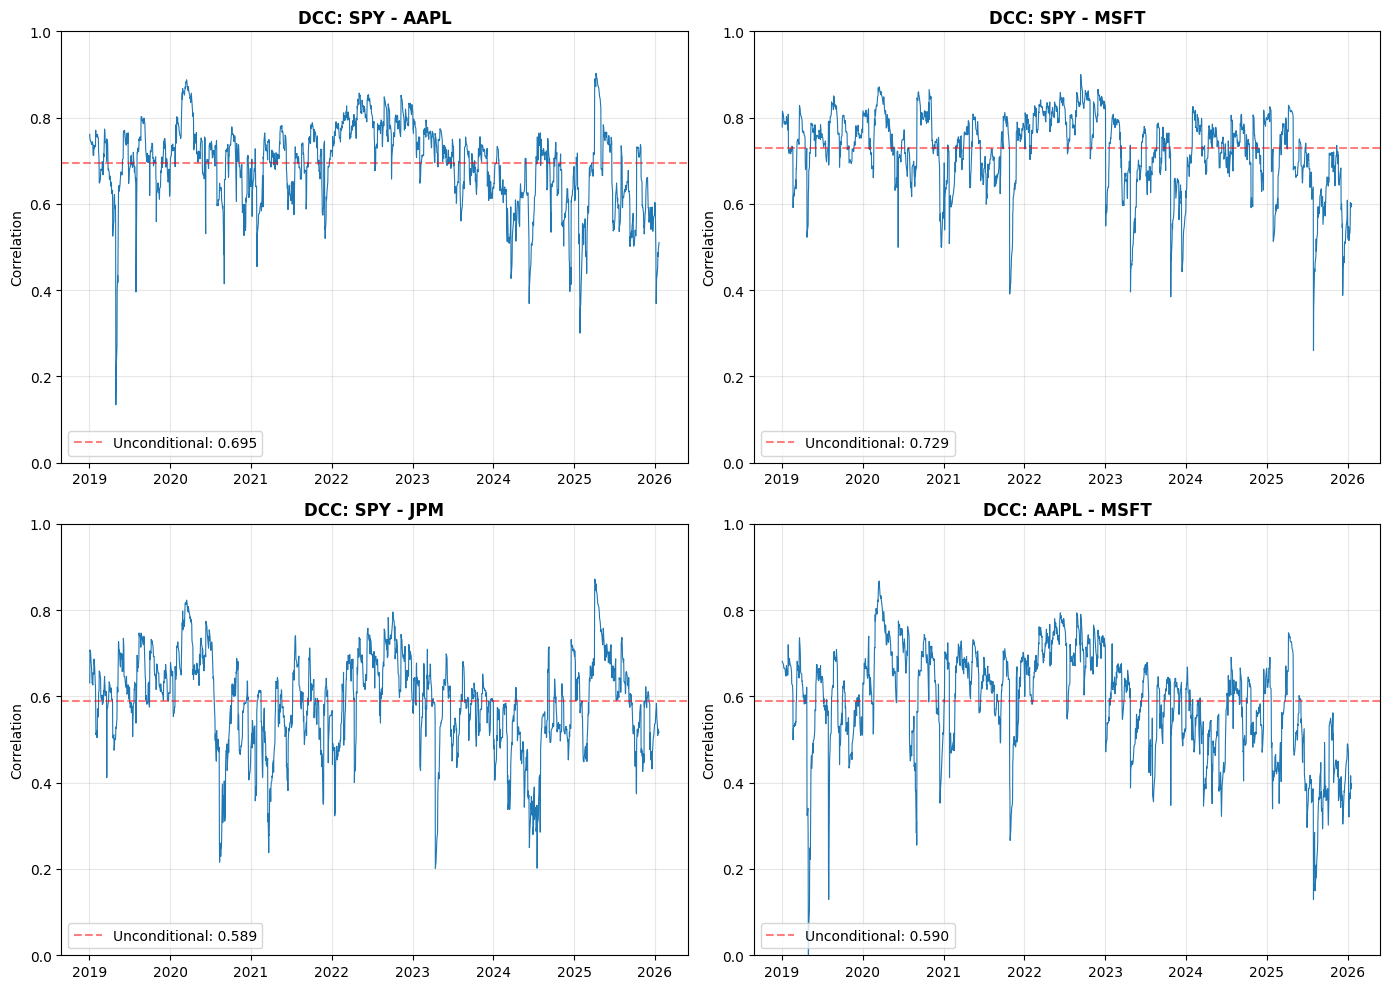

In [6]:
# Extract pairwise correlations over time
def extract_pairwise_corr(R_list, i, j):
    """Extract correlation series between asset i and j."""
    return [R[i, j] for R in R_list]

# Plot time-varying correlations
pairs = [(0, 1), (0, 2), (0, 3), (1, 2)]  # SPY-AAPL, SPY-MSFT, SPY-JPM, AAPL-MSFT

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for idx, (i, j) in enumerate(pairs):
    ax = axes[idx]
    corr_series = extract_pairwise_corr(dcc_correlations, i, j)
    ax.plot(z_df.index, corr_series, linewidth=0.8)
    
    # Add unconditional correlation
    ax.axhline(Q_bar[i, j], color='red', linestyle='--', alpha=0.5, 
               label=f'Unconditional: {Q_bar[i, j]:.3f}')
    
    ax.set_title(f'DCC: {assets[i]} - {assets[j]}', fontweight='bold')
    ax.set_ylabel('Correlation')
    ax.set_ylim(0, 1)
    ax.legend(loc='lower left')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 3. Correlation Dynamics Analysis

In [7]:
# Statistics on dynamic correlations
print("\n" + "="*70)
print("DYNAMIC CORRELATION STATISTICS")
print("="*70)
print(f"{'Pair':<15} {'Mean':<10} {'Std':<10} {'Min':<10} {'Max':<10} {'Range':<10}")
print("-"*65)

for i in range(len(assets)):
    for j in range(i+1, len(assets)):
        corr_series = np.array(extract_pairwise_corr(dcc_correlations, i, j))
        pair_name = f"{assets[i]}-{assets[j]}"
        
        print(f"{pair_name:<15} {corr_series.mean():<10.4f} {corr_series.std():<10.4f} "
              f"{corr_series.min():<10.4f} {corr_series.max():<10.4f} "
              f"{corr_series.max() - corr_series.min():<10.4f}")


DYNAMIC CORRELATION STATISTICS
Pair            Mean       Std        Min        Max        Range     
-----------------------------------------------------------------
SPY-AAPL        0.6916     0.0937     0.1343     0.9026     0.7683    
SPY-MSFT        0.7256     0.0873     0.2599     0.8997     0.6398    
SPY-JPM         0.5870     0.1083     0.2016     0.8718     0.6702    
SPY-XOM         0.3674     0.1499     -0.1831    0.7878     0.9709    
AAPL-MSFT       0.5876     0.1227     -0.0305    0.8674     0.8979    
AAPL-JPM        0.2930     0.1556     -0.2202    0.7878     1.0080    
AAPL-XOM        0.1871     0.1515     -0.3307    0.7021     1.0327    
MSFT-JPM        0.2726     0.1512     -0.1654    0.7365     0.9019    
MSFT-XOM        0.1013     0.1650     -0.3948    0.6630     1.0578    
JPM-XOM         0.4280     0.1444     -0.1678    0.7884     0.9562    


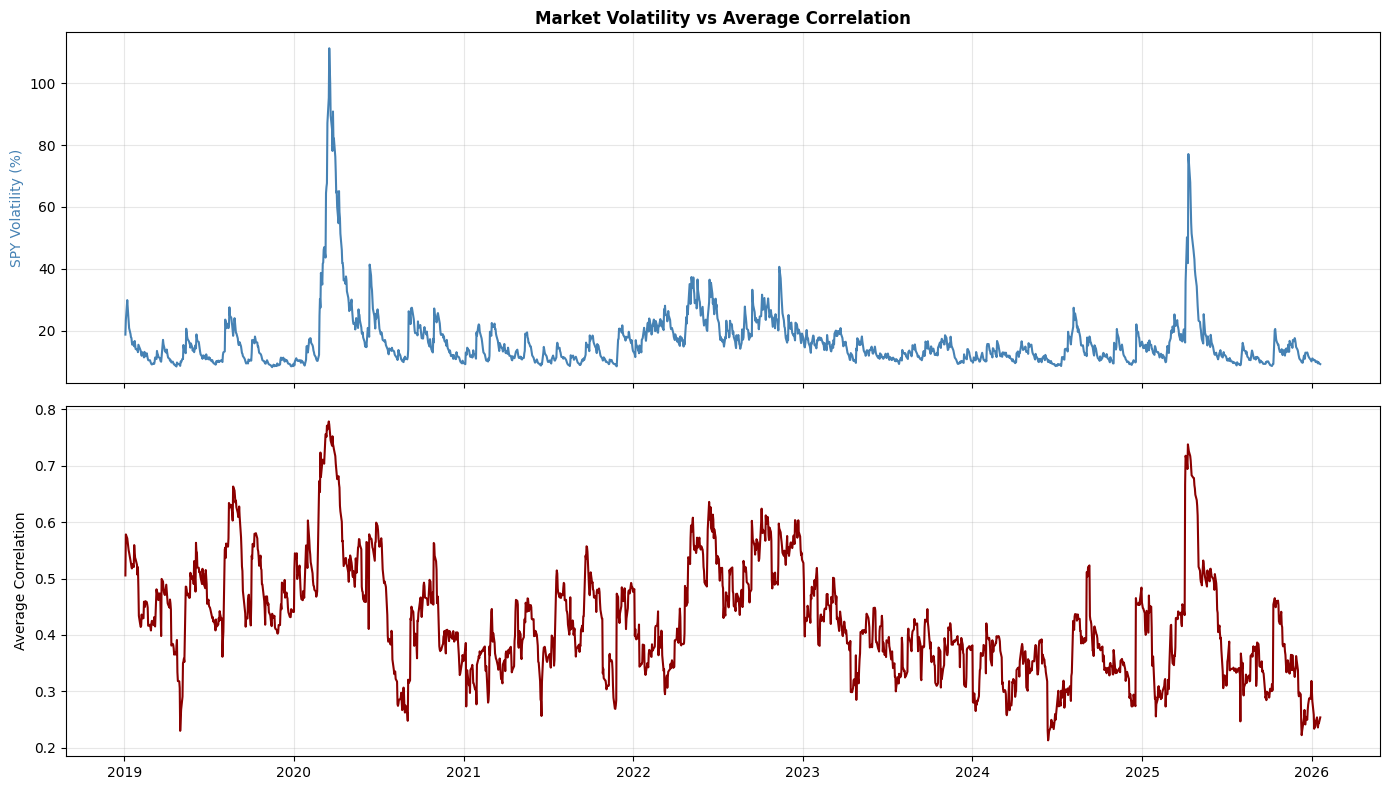


💡 Correlation between volatility and average correlation: 0.6586
   High values suggest correlations spike during volatile periods!


In [8]:
# Correlation breakdown in crises
# Get average correlation over time
avg_corr = []
for R in dcc_correlations:
    # Average off-diagonal elements
    n = R.shape[0]
    upper_tri = R[np.triu_indices(n, k=1)]
    avg_corr.append(upper_tri.mean())

avg_corr_series = pd.Series(avg_corr, index=z_df.index)

# Compare with market volatility
market_vol = vol_df['SPY'] * np.sqrt(TRADING_DAYS)

fig, axes = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

ax1 = axes[0]
ax1.plot(market_vol, color='steelblue')
ax1.set_ylabel('SPY Volatility (%)', color='steelblue')
ax1.set_title('Market Volatility vs Average Correlation', fontweight='bold')
ax1.grid(True, alpha=0.3)

ax2 = axes[1]
ax2.plot(avg_corr_series, color='darkred')
ax2.set_ylabel('Average Correlation')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Correlation between volatility and average correlation
vol_corr_corr = market_vol.corr(avg_corr_series)
print(f"\n💡 Correlation between volatility and average correlation: {vol_corr_corr:.4f}")
print("   High values suggest correlations spike during volatile periods!")

## 4. Portfolio Volatility with DCC

In [9]:
# Calculate portfolio volatility using DCC
# Equal weight portfolio
weights = np.array([1/len(assets)] * len(assets))

def portfolio_volatility_dcc(weights, cond_vols, dcc_corrs):
    """Calculate portfolio volatility over time using DCC."""
    T = len(dcc_corrs)
    port_vol = np.zeros(T)
    
    for t in range(T):
        # Diagonal volatility matrix
        D_t = np.diag(cond_vols.iloc[t].values)
        R_t = dcc_corrs[t]
        
        # Covariance matrix
        H_t = D_t @ R_t @ D_t
        
        # Portfolio variance
        port_var = weights @ H_t @ weights
        port_vol[t] = np.sqrt(port_var)
    
    return pd.Series(port_vol, index=cond_vols.index[:T])

# Align data
vol_df_aligned = vol_df.loc[z_df.index]

port_vol_dcc = portfolio_volatility_dcc(weights, vol_df_aligned, dcc_correlations)

# Compare with constant correlation assumption
def portfolio_volatility_constant(weights, cond_vols, const_corr):
    """Calculate portfolio volatility with constant correlation."""
    T = len(cond_vols)
    port_vol = np.zeros(T)
    
    for t in range(T):
        D_t = np.diag(cond_vols.iloc[t].values)
        H_t = D_t @ const_corr @ D_t
        port_var = weights @ H_t @ weights
        port_vol[t] = np.sqrt(port_var)
    
    return pd.Series(port_vol, index=cond_vols.index)

port_vol_const = portfolio_volatility_constant(weights, vol_df_aligned, Q_bar)

print("\n" + "="*60)
print("PORTFOLIO VOLATILITY COMPARISON")
print("="*60)
print(f"{'Metric':<25} {'DCC':<15} {'Constant Corr':<15}")
print("-"*55)
print(f"{'Mean Vol (ann %)':<25} {(port_vol_dcc * np.sqrt(TRADING_DAYS)).mean():<15.2f} {(port_vol_const * np.sqrt(TRADING_DAYS)).mean():<15.2f}")
print(f"{'Max Vol (ann %)':<25} {(port_vol_dcc * np.sqrt(TRADING_DAYS)).max():<15.2f} {(port_vol_const * np.sqrt(TRADING_DAYS)).max():<15.2f}")
print(f"{'Vol of Vol':<25} {(port_vol_dcc * np.sqrt(TRADING_DAYS)).std():<15.2f} {(port_vol_const * np.sqrt(TRADING_DAYS)).std():<15.2f}")


PORTFOLIO VOLATILITY COMPARISON
Metric                    DCC             Constant Corr  
-------------------------------------------------------
Mean Vol (ann %)          18.26           18.10          
Max Vol (ann %)           102.78          84.34          
Vol of Vol                9.01            7.19           


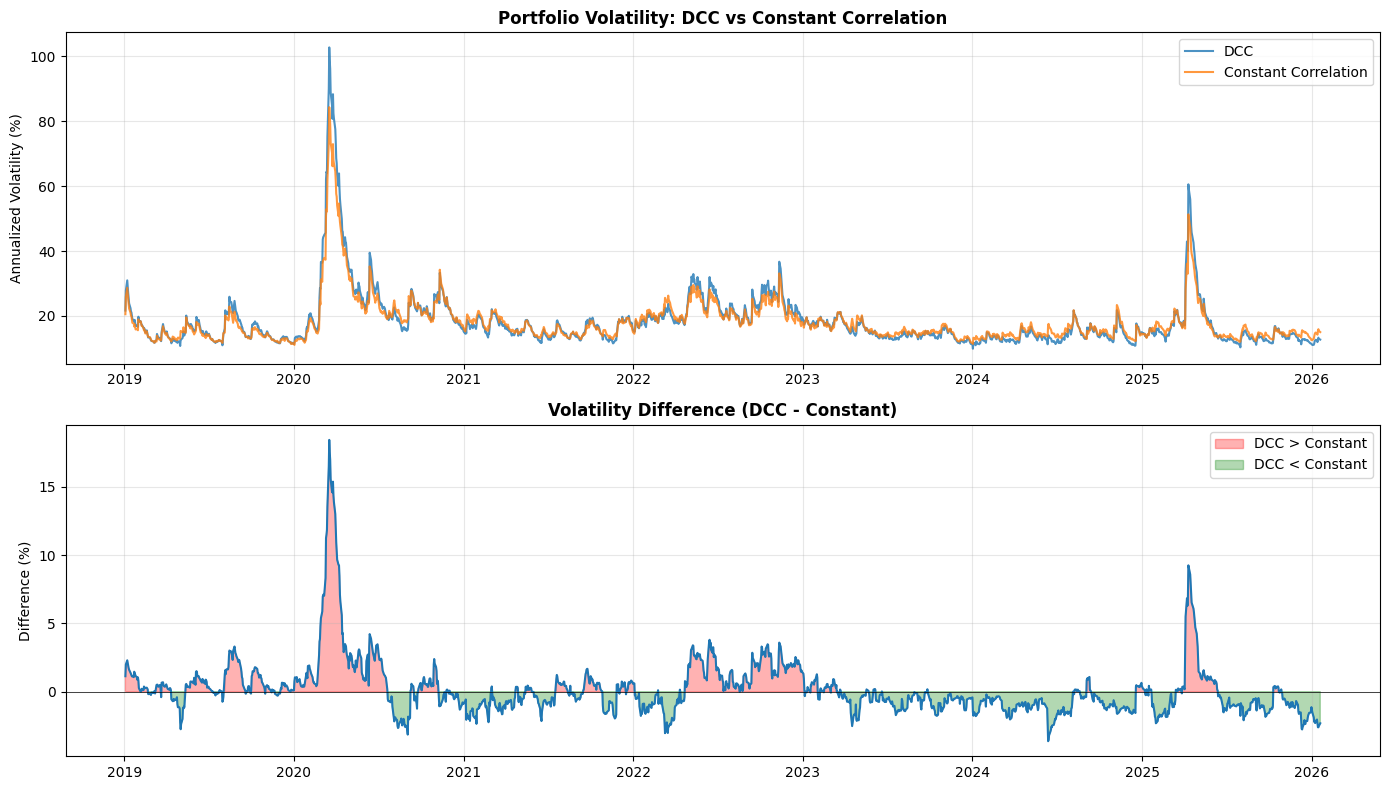

In [10]:
# Plot portfolio volatility comparison
fig, axes = plt.subplots(2, 1, figsize=(14, 8))

ax1 = axes[0]
ax1.plot(port_vol_dcc * np.sqrt(TRADING_DAYS), label='DCC', alpha=0.8)
ax1.plot(port_vol_const * np.sqrt(TRADING_DAYS), label='Constant Correlation', alpha=0.8)
ax1.set_title('Portfolio Volatility: DCC vs Constant Correlation', fontweight='bold')
ax1.set_ylabel('Annualized Volatility (%)')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Difference
ax2 = axes[1]
diff = (port_vol_dcc - port_vol_const.loc[port_vol_dcc.index]) * np.sqrt(TRADING_DAYS)
ax2.plot(diff)
ax2.axhline(0, color='black', linewidth=0.5)
ax2.fill_between(diff.index, 0, diff.values, where=diff > 0, alpha=0.3, color='red', label='DCC > Constant')
ax2.fill_between(diff.index, 0, diff.values, where=diff < 0, alpha=0.3, color='green', label='DCC < Constant')
ax2.set_title('Volatility Difference (DCC - Constant)', fontweight='bold')
ax2.set_ylabel('Difference (%)')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 5. Rolling Window Correlation Comparison

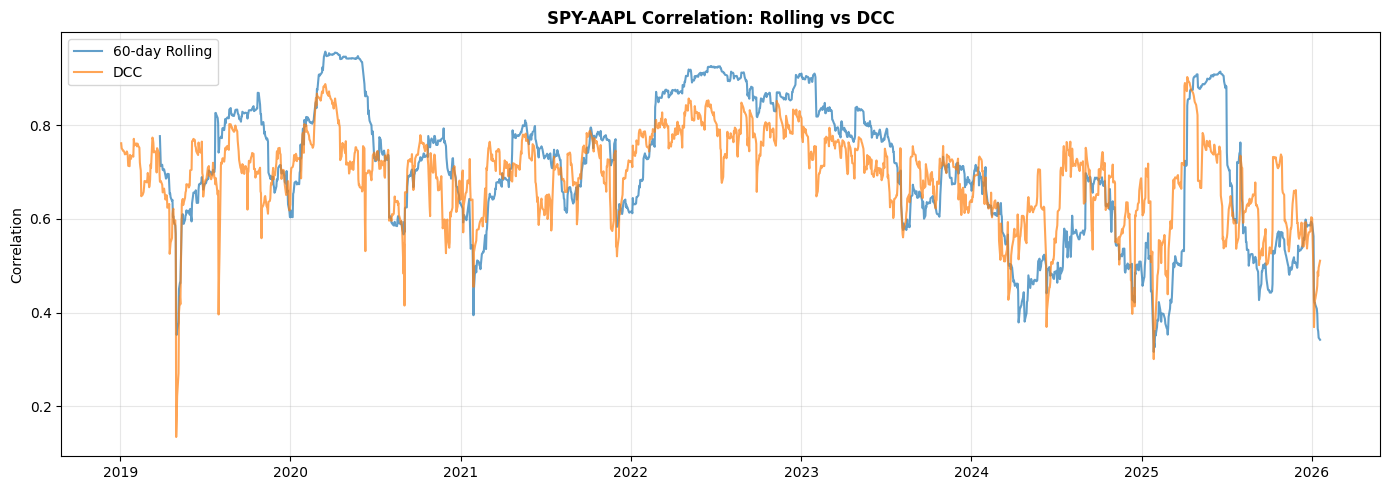


💡 Key Differences:
   - Rolling window: Slow to react, jumps when old data leaves window
   - DCC: Smooth, exponential weighting of past information


In [11]:
# Compare DCC with rolling window correlation
window = 60  # 60-day rolling window

# Rolling correlation between SPY and AAPL
rolling_corr = asset_returns['SPY'].rolling(window).corr(asset_returns['AAPL'])
dcc_spy_aapl = pd.Series(extract_pairwise_corr(dcc_correlations, 0, 1), index=z_df.index)

fig, ax = plt.subplots(figsize=(14, 5))
ax.plot(rolling_corr, label=f'{window}-day Rolling', alpha=0.7)
ax.plot(dcc_spy_aapl, label='DCC', alpha=0.7)
ax.set_title('SPY-AAPL Correlation: Rolling vs DCC', fontweight='bold')
ax.set_ylabel('Correlation')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\n💡 Key Differences:")
print("   - Rolling window: Slow to react, jumps when old data leaves window")
print("   - DCC: Smooth, exponential weighting of past information")

## Key Takeaways

1. **DCC captures time-varying correlations** - essential for risk management
2. **Two-step estimation**: Univariate GARCH first, then DCC
3. **Correlations spike during crises** - diversification fails when needed most
4. **Better than rolling windows** - smoother, more responsive
5. **Portfolio risk** - using constant correlation underestimates tail risk

### DCC Formula Summary
$$Q_t = (1-a-b)\bar{Q} + a(z_{t-1}z_{t-1}') + b Q_{t-1}$$
$$R_t = \text{diag}(Q_t)^{-1/2} Q_t \text{diag}(Q_t)^{-1/2}$$

---
*Next: Day 5 - Volatility Forecasting*